In [287]:
from minwon_maru.engine.init.load_docs import load_docs
from minwon_maru.engine.init.check_consistency import check_filesystem_concurrency
from minwon_maru.engine.init.make_metadata import generate_metadata

if check_filesystem_concurrency():
    pass
else :
    result = await load_docs()
    sever_id = "111"
    metadata = await generate_metadata(sever_id)


7
7
[성공] 파일시스템과 metadata.json이 동기화되어 있습니다.


In [ ]:
# basic_CRAG.py  (chain.py + basic_CRAG.py 통합 / search_document CRAG 내부 완전 통합)
from pathlib import Path
import json
from typing import Annotated, List, Any, Optional
from typing_extensions import TypedDict

# ===== chain.py 에 있던 import =====
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
# from langchain_openai import ChatOpenAI  # (원본 주석 유지)

from speak_note.tools.context import create_metadata_retriever_with_map, create_workpages_retriever
from speak_note.tools.llms import llm_list
from speak_note.tools.personal_info_keeper import personal_info_keeper
import asyncio

from langchain.schema import Document
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
# from langchain_openai import OpenAIEmbeddings  # (원본 주석 유지)

# ===== basic_CRAG.py 에 있던 import =====
from langgraph.graph import END, StateGraph, START
from speak_note.prompts import prompt
from speak_note.tools import llms
from langchain_teddynote.tools.tavily import TavilySearch
from pydantic import BaseModel, Field


In [275]:
#########################################################################################################
# 1) 프롬프트 정의 (chain.py 원본 유지)
#########################################################################################################



# ===========================
# Grader Definition
# ===========================
class GradeDocuments(BaseModel):
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")


#########################################################################################################
# basic_CRAG.py 원본 타입
#########################################################################################################
class GraphState(TypedDict):
    input: Annotated[str, "The question text from user"]
    ability: Annotated[str, "The domain ability (예: 민원 행정, 수학 등)"]
    generation: Annotated[str, "The generation from the LLM"]
    web_search: Annotated[str, "Whether to add search (Yes/No)"]
    relavent_workpages : Annotated[str, "relavent workpages link info"]
    context : Annotated[str, "relavent documents info"]
    documents: Annotated[Optional[List[Document]], "Documents already retrieved (may be empty or None)"]

In [247]:
# prompt_tpl = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "당신은 {ability}에 능숙한 친절한 민원 응대 상담원입니다. "
#             "아래 문서 맥락(Context)을 우선적으로 참고해 정확하게 답변하세요. "
#             "모르면 모른다고 답하세요.\n\n"
#             "[Context]\n{context}"
#         ),
#         MessagesPlaceholder("history"),
#         ("human", "{input}"),
#     ]
# )
# base_chain = (
#     {
#         "ability": RunnableLambda(lambda x: x["ability"]),
#         "context": RunnableLambda(lambda x: x["context"]),
#         "history": RunnableLambda(lambda x: x.get("history", [])),  # 초기 로드용(선택)
#         "input":   RunnableLambda(lambda x: x["input"]),
#     }
#     | prompt
#     | llm_list["gpt-4o-mini"]
# )
# # 세션 히스토리 저장소 (데모)
session_store = {}

def get_session_history(session_id: str) -> ChatMessageHistory:
    if session_id not in session_store:
        session_store[session_id] = ChatMessageHistory()
    return session_store[session_id]


prompt_tpl = ChatPromptTemplate.from_messages(
    [
        ("system",
         "당신은 {ability}에 능숙한 상담원입니다.\n\n[Context]\n{context}"),
        MessagesPlaceholder("history"),      # 반드시 list[BaseMessage]
        ("human", "{input}"),
    ]
)

base_chain = (
    {
        "ability": RunnableLambda(lambda x: x["ability"]),
        "context": RunnableLambda(lambda x: x.get("context", "")),
        "history": RunnableLambda(lambda x: x.get("history", [])),   # 중요!
        "input":   RunnableLambda(lambda x: x["input"]),
    }
    | prompt_tpl
    | llm_list["gpt-4o-mini"]
)


# RunnableWithMessageHistory로 감싸서, 모델과의 대화 히스토리를 자동 축적
with_history = RunnableWithMessageHistory(
    base_chain,
    lambda config: get_session_history(config["configurable"]["session_id"]),
    input_messages_key="input",       # 사용자의 현재 발화가 저장될 키
    history_messages_key="history",   # 프롬프트에서 MessagesPlaceholder로 참조하는 키
)

# # 세션 호출
# resp1 = with_history.invoke(
#     {"ability": "행정 지식", "context": "사전 예약제 운영", "input": "강당 대여 가능한가요?"},
#     config={"configurable": {"session_id": "user-123"}},
# )
# print(resp1)

# resp2 = with_history.invoke(
#     {"ability": "행정 지식", "context": "사전 예약제 운영", "input": "그럼 요금은 얼마인가요?"},
#     config={"configurable": {"session_id": "user-123"}},
# )
# print(resp2)


In [185]:
embeddings = OpenAIEmbeddings()
metadata_path = Path("/Users/yujin/Desktop/코딩shit/python_projects/대한민국해커톤/민원마루ver1/datas/metadata.json")
workpages_path = Path("/Users/yujin/Desktop/코딩shit/python_projects/대한민국해커톤/민원마루ver1/datas/reference/work_page_info.json")

In [186]:
metadata_retriever, summarize_map = create_metadata_retriever_with_map(
    metadata_path,
    embeddings,
)

In [187]:
workpage_retriever = create_workpages_retriever(
        workpages_path,
        embeddings,
    )

In [188]:

# 1) 프롬프트 정의
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "당신은 {ability}에 능숙한 민원 응대 상담원입니다. "
            "아래 문서 맥락(Context)을 우선적으로 참고해 정확하게 답변하세요. "
            "모르면 모른다고 답하세요.\n\n"
            "[Context]\n{context}"
        ),
        MessagesPlaceholder("history"),
        ("human", "{input}"),
    ]
)

# {'history'}.  Expected: ['ability', 'context', 'history', 'input'] 
# Received: ['input', 'ability', 'context']\nNote: if you intended {history} 

In [ ]:

store = {}

# [추가] CRAG 인스턴스의 세션 히스토리 getter
def get_session_history( session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

# ==================== 노드 함수 ====================
def search_document(state: GraphState):
    """
    (통합) chain.py의 search_document 로직을 CRAG 내부로 완전 통합.
    state에 documents/context/doc_retriever를 채워서 반환.
    """
    query = state["input"]
    outputs = dict(state)

    # 1. 질의와 유사한 상위 문서 가져오기
    candidate_docs = metadata_retriever.get_relevant_documents(query)

    # 2. 질의와 유사한 workpage 검색
    selected_work = workpage_retriever.get_relevant_documents(query)

    # 3. 선택된 문서를 chunk로 분할
    split_documents = []
    for d in candidate_docs:
        origin_info = summarize_map.get(d.page_content, {})
        json_path = origin_info.get("path")
        if json_path:
            with open(json_path, "r", encoding="utf-8") as f:
                origin_json = json.load(f)
            if isinstance(origin_json, list) and len(origin_json) > 0:
                content = origin_json[0].get("page_content", "")
            else:
                content = origin_json.get("content", "") if isinstance(origin_json, dict) else ""
        else:
            content = d.page_content

        splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            encoding_name="cl100k_base",
            chunk_size=300,   
            chunk_overlap=50,
            separators=["\n### ","\n## ","\n# ","\n\n","\n"," ",""]
            )
        base_doc = Document(page_content=content, metadata={"path": json_path})
        split_documents.extend(splitter.split_documents([base_doc]))

    # 4. 벡터스토어 생성 후, query와 0.5 이상 문서 chunk 검색
    if split_documents:
        vectorstore = FAISS.from_documents(
            split_documents,
            embedding=metadata_retriever.vectorstore.embedding_function
        )
        doc_retriever = vectorstore.as_retriever(
            search_type="similarity_score_threshold",
            search_kwargs={"score_threshold": 0.5, "k": 8}
        )
        retrieved_chunks = doc_retriever.get_relevant_documents(query)
    else:
        doc_retriever = None
        retrieved_chunks = []

    # context 조합
    context_parts=[]
    workpath_context_parts = []
    if selected_work:
        workpath_context_parts.append("[행정 Work Pages]")
        for w in selected_work:
            url = w.metadata.get("url") or w.metadata.get("page_link", "")
            desc = w.metadata.get("desc", "")
            summarize = w.page_content
            workpath_context_parts.append(f"- {desc or summarize} | {url}")

    if retrieved_chunks:
        context_parts.append("[관련 문서]")
        for c in retrieved_chunks:
            context_parts.append(c.page_content)

    context_str = "\n".join(context_parts)
    workpath_context_str = "\n".join(workpath_context_parts)
    # 결과 주입
    outputs["documents"] = retrieved_chunks
    outputs["relavent_workpages"] = workpath_context_str
    print("===============context===============")
    # print(context_str)
    outputs["context"] = context_str
    outputs["doc_retriever"] = doc_retriever
    return outputs


In [216]:
# 실행 확인용 state (간단 예시)
state = {
    "input": "금정구도서관은 화요일에 몇시까지 운영하지? 주차비는 있어? 회원증 있으면 무료인가?",
    "ability": "행정 지식",
    "documents": [],
    "history": []
}

# 함수 실행
result = search_document(state)

# print("\n[리턴 결과 확인]")
# print("context:\n", result.get("context", ""))
# print("documents:", [d.page_content[:50] for d in result.get("documents", [])])


===============context===============


In [217]:
# print(result["context"])

In [218]:
# result["documents"]

In [248]:
 # 평가자 정의
structured_llm_grader = llm_list["gpt-4.1-mini"].with_structured_output(GradeDocuments)

# 🔽 추가: 문서-질문 관련성 그레이더 프롬프트 + 체인
grader_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a retrieval evaluator. "
     "Given a user question and a document chunk, decide if the document may help answer the question. "
     "Be lenient: if the chunk contains related terms, context, or background that could help, answer 'yes'. "
     "Output 'binary_score' as 'yes' or 'no'."),
    ("human", "Question:\n{question}\n\nDocument:\n{document}")
])
retrieval_grader = grader_prompt | structured_llm_grader


def grade_documents(state: GraphState):
    print("\n==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====\n")
    question = state.get("input", "")
    documents = state.get("documents") or []

    
    # 각 문서에 대해서 적합성 검사
    # 검사 조건 완화가 필요해 보인다.
    filtered_docs = []
    for d in documents:
        doc_text = (d.page_content or "")  # 과도한 토큰 방지로 트렁케이트 -> 제거
        try:
            grade = retrieval_grader.invoke({"question": question, "document": doc_text})
            keep = (grade.binary_score or "").strip().lower() == "yes"
        except Exception as e:
            print(f"==== [GRADE: ERROR] ==== {e}")
            # 에러 시 보수적으로 유지(망실 방지)
            keep = True

        if keep:
            print("==== [GRADE: DOCUMENT RELEVANT] ====")
            filtered_docs.append(d)
        else:
            print("==== [GRADE: DOCUMENT NOT RELEVANT] ====")


    # 문서가 없으면 웹서치로 전환 -> filtered_docs가 없을때도 전환.
    # context가 없이 제공되는 상황을 방지한다. 어떤일이 있어서 context는 웹서치 기반이라도 반환하게 해야힘
    if not documents or not filtered_docs:
        print("==== [GRADE: NO DOCUMENTS] ====")
        return {"documents": [], "web_search": "Yes"}
    
    # 기존 context에서 [관련 문서] 섹션만 교체하여 유지(Work Pages는 보존)
    original_context = state.get("context", "")
    before, sep, _after = original_context.partition("[관련 문서]")

    new_context_parts = [before.strip()] if before.strip() else []
    if filtered_docs:
        new_context_parts.append("[관련 문서]")
        for c in filtered_docs:
            new_context_parts.append(c.page_content)

    new_context = "\n".join(new_context_parts)
    # print("new context \n", new_context)
    web_search_flag = "No" if filtered_docs else "Yes"

    state["documents"] = filtered_docs
    state["web_search"] = web_search_flag
    state["context"] = new_context

    print("web_search_flag : ", web_search_flag)
    return state

In [249]:
from langchain.prompts import PromptTemplate

web_search_tool = TavilySearch(max_results=3)

# 문자열 → PromptTemplate로 감싸기
web_search_prompt = PromptTemplate.from_template("""
당신은 한국 지방자치단체의 민원 상담을 돕는 스마트 어시스턴트입니다.
현재 제공된 행정 문서에서는 사용자의 질문에 대한 직접적인 답을 찾지 못했습니다.
따라서 외부 검색 결과(웹 정보)를 참고하여 민원인에게 도움이 될 수 있는 답변을 제공합니다.

아래는 검색을 통해 수집한 컨텍스트이며, 사용자의 질문은 해당 주제에 대한 안내를 요청한 것입니다.
당신의 역할은 이 컨텍스트를 기반으로 **명확하고 신뢰성 있게 정리된 답변**을 제공하는 것입니다.
가능하다면 공공기관·지자체 공식 사이트, 행정절차, 연락처 등 신뢰할 수 있는 정보를 강조하세요.  

만약 컨텍스트에 해당 정보가 전혀 없거나 불확실하다면, 
'현재 제공된 자료에는 정확한 답변이 없습니다. 관련 부서나 공식 홈페이지를 통해 확인하시길 권장드립니다.'라고 정직하게 답하세요.

최종 출력은 민원 상담원답게 공손한 한국어 문장으로 작성하세요.
현재 드리는 정보는 관련 문서를 찾을수 없어서 웹서치 기반으로 드리는 정보라는 점을 말씀드리세요.
#검색 컨텍스트:
{context}

#사용자 질문:
{question}

#답변:
""")

def web_search(state: GraphState):
    print("\n==== [WEB SEARCH] ====\n")
    query_text = state["input"]
    docs = web_search_tool.invoke({"query": query_text})

    # 🔽 docs -> 사람이 읽기 좋은 context 문자열로 변환
    if docs:
        context_parts = []
        for d in docs[:3]:  # 최대 3개까지만
            url = d.get("url", "")
            title = d.get("title", "")
            content = d.get("content", "")
            if title:
                context_parts.append(f"[{title}]")
            if content:
                context_parts.append(content)
            if url:
                context_parts.append(f"출처: {url}")
            context_parts.append("")  # 줄바꿈
        context = "\n".join(context_parts).strip()
    else:
        context = llm_list["gpt-4.1-mini"].invoke(query_text)

    print("web search result : \n", context)
    state["documents"] = docs
    state["context"] = context

    web_search_input = {
        "context": context,
        "question": query_text
    }

    # 디버깅용 prompt 출력
    final_prompt = web_search_prompt.invoke(web_search_input)
    print(final_prompt)

    chain = (
        web_search_prompt
        | llm_list["gpt-4o-mini"]
        | StrOutputParser()
    )

    generated = chain.invoke(web_search_input)
    state["generation"] = generated
    return state



In [223]:
web_generated = web_search(result)


==== [WEB SEARCH] ====

web search result : 
 [( 이용시간 ) | 이용안내 | 도서관안내 | 부산광역시 금정도서관 - 금정구청]
Missing: 화요일 하지? 주차비 회원증 있으면 무료
출처: https://library.geumjeong.go.kr/index.geumj?menuCd=DOM_000000609002001000

[( 도서회원가입 ) | 이용안내 | 도서관안내 | 부산광역시 금정도서관]
Missing: 화요일 하지? 주차비 있으면 인가?
출처: https://www.geumjeong.go.kr/index.geumj?menuCd=DOM_000000609002002000

[부산 금정구 도서관 - 어릴 때 자주 다녔던 금정도서관 - 블로그]
Missing: 화요일 몇시 운영 있어? 회원증
출처: https://m.blog.naver.com/allisa_kim/223000031557
text="\n당신은 한국 지방자치단체의 민원 상담을 돕는 스마트 어시스턴트입니다.\n현재 제공된 행정 문서에서는 사용자의 질문에 대한 직접적인 답을 찾지 못했습니다.\n따라서 외부 검색 결과(웹 정보)를 참고하여 민원인에게 도움이 될 수 있는 답변을 제공합니다.\n\n아래는 검색을 통해 수집한 컨텍스트이며, 사용자의 질문은 해당 주제에 대한 안내를 요청한 것입니다.\n당신의 역할은 이 컨텍스트를 기반으로 **명확하고 신뢰성 있게 정리된 답변**을 제공하는 것입니다.\n가능하다면 공공기관·지자체 공식 사이트, 행정절차, 연락처 등 신뢰할 수 있는 정보를 강조하세요.  \n\n만약 컨텍스트에 해당 정보가 전혀 없거나 불확실하다면, \n'현재 제공된 자료에는 정확한 답변이 없습니다. 관련 부서나 공식 홈페이지를 통해 확인하시길 권장드립니다.'라고 정직하게 답하세요.\n\n최종 출력은 민원 상담원답게 공손한 한국어 문장으로 작성하세요.\n현재 드리는 정보는 관련 문서를 찾을수 없어서 웹서치 기반으로 드리는 정보라는 점을 말씀드리세요.\n#검

In [ ]:
# generate_prompt = PromptTemplate.from_template("""
# 당신은 한국 지방자치단체의 민원 상담을 돕는 스마트 어시스턴트입니다.
# 현재 제공된 행정 문서에서는 사용자의 질문에 대한 직접적인 답을 찾지 못했습니다.
# 따라서 외부 검색 결과(웹 정보)를 참고하여 민원인에게 도움이 될 수 있는 답변을 제공합니다.

# 아래는 관련 문서를 통해 얻은 컨텍스트이며, 사용자의 질문은 해당 주제에 대한 안내를 요청한 것입니다.
# 당신의 역할은 이 컨텍스트를 기반으로 **명확하고 신뢰성 있게 정리된 답변**을 제공하는 것입니다.
# 가능하다면 공공기관·지자체 공식 사이트, 행정절차, 연락처 등 신뢰할 수 있는 정보를 강조하세요.  

# 만약 컨텍스트에 해당 정보가 전혀 없거나 불확실하다면, 
# '현재 제공된 자료에는 정확한 답변이 없습니다. 관련 부서나 공식 홈페이지를 통해 확인하시길 권장드립니다.'라고 정직하게 답하세요.

# 최종 출력은 민원 상담원답게 공손한 한국어 문장으로 작성하세요.

# #검색 컨텍스트:
# {context}

# #사용자 질문:
# {input}

# #답변:
# """)


# def generate( state: GraphState):
#     print("\n==== GENERATE ====\n")
#     query_text = state["input"]
#     print("======query_text======")
#     context = state["context"]
#     print("======context======")
#     chain = (
#         generate_prompt
#         | llm_list["gpt-4.1-mini"]
#         | StrOutputParser()
#     )
#     generate = chain.invoke({"context" : context, "input" : query_text})
#     state["generation"] = generate
#     return state


In [279]:
def generate( state: GraphState):
    print("\n==== GENERATE ====\n")
    query_text, ability = state["input"], state["ability"]
    print("======query_text======")
    print(query_text)
    history = state.get("history", [])
    context = state.get("context", "")
    print("======context======")
    print(context)
    raw_input = state.get("raw_input", query_text)  # ← 추가

    generation = base_chain.invoke({
        "input": query_text,
        "raw_input": raw_input,      # ← 추가: 히스토리 저장용 원본
        "ability": ability,
        "history": history,
        "context": context
    })
    state["generation"] = generation
    return state


In [280]:
# 실행 확인용 state (간단 예시)
state = {
    "input": "금정구도서관은 화요일에 몇시까지 운영하지? 주차비는 있어? 회원증 있으면 무료인가?",
    "ability": "행정 지식",
    "documents": [],
    "history": []
}

# 함수 실행
result = search_document(state)

# 함수 검사
graded_result = grade_documents(result)

# 최종생성
generated = generate(graded_result)

===============context===============

==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
web_search_flag :  No

==== GENERATE ====

======query_text======
금정구도서관은 화요일에 몇시까지 운영하지? 주차비는 있어? 회원증 있으면 무료인가?
======context======
[행정 Work Pages]
- 모바일 주민등록증 발급 안내 | https://www.mobileid.go.kr/mip/hps/issuReqstGuidance/issuReqstGuidanceMrc.do
[관련 문서]
고 수탁자가 처리하는 주차장 관리 업무 전반에 대해 지도 · 감독한다.
제4조(운영시간) ① 주차장 운영시간은 다음 각 호와 같다. 다만, 구청장은 주차수요 등 주차 여건에 따라 운영시간을 조정할 수 있
다.
1. 화요일~금요일 : 09:00~22:00
2. 토요일·일요일 : 09:00~17:00
② 「부산광역시 금정구 금정도서관 운영 조례 시행규칙」에 따른 도서관 휴관일에는 주차장을 폐쇄한다.
③ 구청장은 부산광역시 금정구의 주요행사 등 필요한 경우 주차장을 무료로 운영할 수 있다.
제5조(주차요금) ① 주차장은 유료로 운영한다.
1. 열람실 <개정 2020.7.1.>
가. 월요일 : 09:00~18:00 (단, 매월 첫째 월요일

In [281]:
generated["generation"]

AIMessage(content='금정구 도서관은 화요일에 오전 9시부터 오후 10시까지 운영합니다. 주차장은 유료로 운영되며, 입차 후 최초 30분은 무료이고, 이후 10분마다 100원이 징수됩니다. 하루 최대 주차 요금은 4,700원을 초과하지 않습니다.\n\n회원증이 있는 경우에도 주차요금 면제 혜택은 제공되지 않습니다. 다만, 문화교실 강사 및 회원은 3시간의 주차요금이 면제됩니다. 추가적인 감면 혜택이 필요하다면, 관련 규정이나 요건을 확인하고 필요한 자료를 제시해야 합니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 147, 'prompt_tokens': 1374, 'total_tokens': 1521, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C9dX3gvhquQLDc6xgK82wFAqiBgAm', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e5ac331f-e5a0-4fa9-be68-acf227c0537b-0', usage_metadata={'input_tokens': 1374, 'output_tokens': 147, 'total_tokens': 1521, 'input_token_details': {'audio': 0, 'cache_re

In [228]:

def passthrough( state: GraphState):
    print("==== [PASS THROUGH] ====")
    # print("Final Answer:", state["generation"])
    return state

def decide_to_generate( state: GraphState):
    print("==== [ASSESS GRADED DOCUMENTS] ====")
    return "web_search_node" if state["web_search"] == "Yes" else "generate"



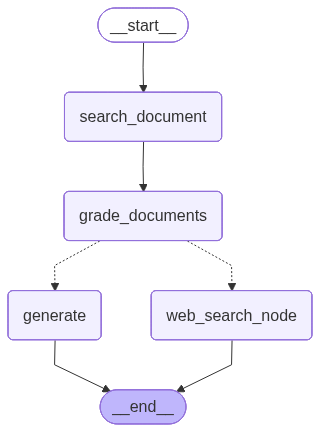

In [282]:
workflow = StateGraph(GraphState)

workflow.add_node("search_document", search_document)   # ← 먼저 검색
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("web_search_node", web_search)


workflow.add_edge(START, "search_document")
workflow.add_edge("search_document", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "web_search_node": "web_search_node",
        "generate": "generate",
    },
)
workflow.add_edge("web_search_node", END)
workflow.add_edge("generate", END)   # 누락됐던 엣지 추가

app = workflow.compile()
app

In [285]:
query = {
    "input": "금정구도서관은 화요일에 몇시까지 운영하지? 주차비는 있어? 회원증 있으면 무료인가?",
    "ability": "행정 지식",
    "documents": [],
    "context" : "",
    "history": []
}
app_generated = app.invoke(query)

===============context===============

==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
web_search_flag :  No
==== [ASSESS GRADED DOCUMENTS] ====

==== GENERATE ====

======query_text======
금정구도서관은 화요일에 몇시까지 운영하지? 주차비는 있어? 회원증 있으면 무료인가?
======context======
[관련 문서]
고 수탁자가 처리하는 주차장 관리 업무 전반에 대해 지도 · 감독한다.
제4조(운영시간) ① 주차장 운영시간은 다음 각 호와 같다. 다만, 구청장은 주차수요 등 주차 여건에 따라 운영시간을 조정할 수 있
다.
1. 화요일~금요일 : 09:00~22:00
2. 토요일·일요일 : 09:00~17:00
② 「부산광역시 금정구 금정도서관 운영 조례 시행규칙」에 따른 도서관 휴관일에는 주차장을 폐쇄한다.
③ 구청장은 부산광역시 금정구의 주요행사 등 필요한 경우 주차장을 무료로 운영할 수 있다.
제5조(주차요금) ① 주차장은 유료로 운영한다.
1. 열람실 <개정 2020.7.1.>
가. 월요일 : 09:00~18:00 (단, 매월 첫째 월요일은 휴실)
나. 화요일~일요일 : 07:00~23:00
2. 자료실
가. 화요일~금요일 : 09:00~18:00
나. 토요일~일요일 : 0

In [286]:
app_generated

{'input': '금정구도서관은 화요일에 몇시까지 운영하지? 주차비는 있어? 회원증 있으면 무료인가?',
 'ability': '행정 지식',
 'generation': AIMessage(content='금정구 도서관은 화요일에 09:00부터 23:00까지 운영합니다. 주차는 유료로 운영되며, 입차 후 최초 30분은 무료입니다. 그 이후로는 10분마다 100원의 요금이 발생하고, 1일 주차요금은 4,700원을 초과하지 않습니다.\n\n회원증과 관련하여 문화교실 강사 및 회원은 3시간 동안 주차요금이 면제됩니다. 그러나 이외의 경우에는 무료가 아닙니다. 주차요금 면제를 원하시면 증명할 수 있는 자료를 제시해야 합니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 138, 'prompt_tokens': 1332, 'total_tokens': 1470, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C9dY7EX4mUbjMaIItarsUidMrmngj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3cc9c7be-5ec7-4632-b19e-70b765d01c28-0', usage_metadata={'input_tokens': 1332, 'output_token

In [265]:
from langchain_core.runnables import RunnableLambda, RunnableWithMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory

# 세션 히스토리 저장소
session_store = {}

def get_session_history(session_id: str) -> ChatMessageHistory:
    if session_id not in session_store:
        session_store[session_id] = ChatMessageHistory()
    return session_store[session_id]


# 단순 분기 라우터
def crag_router(state: dict) -> str:
    # 1) 문서 검색
    s1 = search_document(state)
    # 2) 적합성 평가
    s2 = grade_documents(s1)

    # 3) 분기: 문서 있으면 generate, 없으면 web_search
    if s2.get("web_search") == "Yes":
        s3 = web_search(s2)
    else:
        s3 = generate(s2)

    # 반드시 문자열만 반환 (history 기록 위해)
    return s3["generation"]


# Runnable로 감싸기
router_chain = RunnableLambda(crag_router)

# 히스토리 지원
with_history = RunnableWithMessageHistory(
    router_chain,
    lambda config: get_session_history(config["configurable"]["session_id"]),
    input_messages_key="input",       # 사용자 질문 들어가는 필드
    history_messages_key="history",   # MessagesPlaceholder와 일치
)


In [262]:
query = {
    "input": "금정구 도서관 강당은 화요일에 몇 시까지 운영하나요?",
    "ability": "행정 지식",
    "documents": [],
    "history": []
}

In [266]:
answer = crag_router(query)
print(answer)

===============context===============

==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
web_search_flag :  No

==== GENERATE ====

======query_text======
금정구 도서관 강당은 화요일에 몇 시까지 운영하나요?
======context======
[행정 Work Pages]
- 모바일 주민등록증 발급 안내 | https://www.mobileid.go.kr/mip/hps/issuReqstGuidance/issuReqstGuidanceMrc.do
[관련 문서]
1. 열람실 <개정 2020.7.1.>
가. 월요일 : 09:00~18:00 (단, 매월 첫째 월요일은 휴실)
나. 화요일~일요일 : 07:00~23:00
2. 자료실
가. 화요일~금요일 : 09:00~18:00
나. 토요일~일요일 : 09:00~17:00
② 제1항에도 불구하고 부산광역시 금정구청장(이하 "구청장"이라 한다)은 특별한 사정이 있으면 제1항의 이용시간을 조정할 수 있
다. <개정 2015.12.24.>
제3조(휴관일) ① 도서관의 휴관일은 다음과 같다
1. 매주 월요일


ValueError: Missing keys ['session_id'] in config['configurable'] Expected keys are ['session_id'].When using via .invoke() or .stream(), pass in a config; e.g., chain.invoke({'input': 'foo'}, {'configurable': {'session_id': '[your-value-here]'}})

In [ ]:
resp1 = with_history.invoke(query, config={"configurable": {"session_id": "u1"}})
print("응답1:", resp1)

resp2 = with_history.invoke(
    {"input": "주차비는 있어요?", "ability": "행정 지식"},
    config={"configurable": {"session_id": "u1"}}
)
print("응답2:", resp2)


In [236]:
input = {
    "input": "금정구도서관은 화요일에 몇시까지 운영하지? 주차비는 있어? 회원증 있으면 무료인가?",
    "ability": "행정 지식",
    "documents": [],
    "history": []
}
app_reps = app.invoke(input)

===============context===============

==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
web_search_flag :  No

==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
web_search_flag :  No


TypeError: unhashable type: 'dict'

In [233]:
app_reps

{'input': '금정구도서관은 화요일에 몇시까지 운영하지? 주차비는 있어? 회원증 있으면 무료인가?',
 'ability': '행정 지식',
 'generation': AIMessage(content='금정구도서관은 화요일에 일반적으로 저녁 9시까지 운영합니다. 주차비는 도서관 이용객에게 적용될 수 있으며, 무료 주차는 제공되지 않습니다. 또한, 회원증이 있더라도 주차비 면제는 안 됩니다. 추가적인 정보가 필요하시면 금정구도서관에 직접 문의하시거나 홈페이지를 확인해 보시는 것이 좋습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 89, 'total_tokens': 178, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C9ckbAvKtn3c1VJ3e4SyuDRT8OFQl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2db509a6-560a-467b-af9a-b7077fb12de3-0', usage_metadata={'input_tokens': 89, 'output_tokens': 89, 'total_tokens': 178, 'input_token_details': {'audio': 0, 'cache_read':